# Miller

In [23]:
import warnings
import os
import sys
import gc

In [2]:
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import tqdm
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
from tardis._utils.warnings import suppress_stdout, ignore_predetermined_warnings
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [4]:
num_ood = 1  # not functioning

In [5]:
def get_availables():
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
    
    adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
    adata.obs["age_continuous"] = adata.obs["age"].astype(float)
    df = adata.obs.groupby(["cell_type", "age"]).size()
    df2 = adata.obs.groupby(["cell_type"]).size()
    availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]
    return availables

In [6]:
def calculate_r2_raw(true_array, pred_array, batch_size, drop_last=False, min_item_for_calculation = 10):
    r2s = []
    start_ind = 0
    dropped = False
    for end_ind in range(batch_size, len(true_array)+batch_size*2, batch_size):
        if dropped:
            break
        if end_ind > len(true_array) and not drop_last:
            end_ind = len(true_array)
            dropped = True
        elif end_ind > len(true_array) and drop_last:
            break
        if end_ind - start_ind < min_item_for_calculation:
            break
        
        t = true_array[start_ind:end_ind]
        p = pred_array[start_ind:end_ind]
        r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
        r2s.append(r2)
        start_ind = end_ind
    result = np.mean(r2s)
    if pd.isna(result):
        print(r2s)
    return result

In [7]:
def shuffle_rows_with_rng(matrix, seed):
    shuffled_matrix = matrix.copy()    
    for i, row in enumerate(shuffled_matrix):
        rng = np.random.default_rng(i+seed)
        rng.shuffle(row)
    return shuffled_matrix

In [8]:
def get_deg_masking(adata, top_n):
    with warnings.catch_warnings(), suppress_stdout():
        warnings.simplefilter("ignore")
        from tardis._metricsmixin import MetricsMixin
        
        model_name = f"miller_ood-seed-0_size-{num_ood}"
        dir_path = os.path.join(
            tardis.config.io_directories["models"],
            model_name
        )
        vae = tardis.MyModel.load(dir_path, adata=adata)
        
        from tardis._metricsmixin import MetricsMixin
        labels_full_name, de_genes_dataframe = MetricsMixin._de_genes_metrics_variables_creator(
            model=vae, adata=adata
        )
        de_genes_dataframe = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])
        cell_type_list = adata.obs["cell_type"].to_numpy()
        masking_tensor = MetricsMixin._create_de_genes_mask(
            top_n_genes=top_n,
            de_genes_dataframe=de_genes_dataframe,
            cell_type_list=cell_type_list,
            cell_type_is_not_na=np.ones_like(cell_type_list).astype(bool),
            adata_var_names=pd.Series(list(adata.var.index)),
        )
        return masking_tensor

In [9]:
def get_r2_baseline(ood_seed, batch_size=256):
    with warnings.catch_warnings(), suppress_stdout():
        warnings.simplefilter("ignore")
        from tardis._metricsmixin import MetricsMixin
        adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
        assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
        adata = ad.read_h5ad(adata_file_path)
        adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
        
        adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
        adata.obs["age_continuous"] = adata.obs["age"].astype(float)
        df = adata.obs.groupby(["cell_type", "age"]).size()
        df2 = adata.obs.groupby(["cell_type"]).size()
        availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]
        
        def adata_ood_creator(adata, seed, size):
            rng = np.random.default_rng(seed=seed)
            # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
            # choices = [availables[i] for i in random_choices]
            choices = [availables[ood_seed]]
            choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
            return adata[~choices_bool, :].copy(), choices_bool, choices[0][0]
        
        adata, choices_bool, choice = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

        model_name = f"miller_ood-seed-{ood_seed}_size-{num_ood}"
        dir_path = os.path.join(
            tardis.config.io_directories["models"],
            model_name
        )
        vae = tardis.MyModel.load(dir_path, adata=adata)
        from tardis._disentanglementmanager import DisentanglementManager as DM
    
        adata_main = ad.read_h5ad(adata_file_path)
        adata_main.obs["age"] = adata_main.obs["age"].astype("str").astype("category")
        adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
        adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")
        adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()
            
        kk = ['age', 'integration_donor']
        ood_sample_specs = list(adata_ood.obs[kk].drop_duplicates().to_numpy()[0])
        results = {j: ood_sample_specs[i] for i, j in enumerate(kk)}
        results.update({"ood_seed": ood_seed, "model_name": model_name})
        results.update({"ood_size": adata_ood.shape[0], "reference_size": adata.shape[0]})
        results.update({"model": "baseline"})
        
        r2_kwargs = dict(
            min_item_for_calculation = 10,
            batch_size=batch_size, 
            drop_last=True
        )
        
        results.update({
            "train": calculate_r2_raw(adata.X.A[vae.train_indices], shuffle_rows_with_rng(adata.X.A[vae.train_indices], seed=ood_seed), **r2_kwargs),
            "validation": calculate_r2_raw(adata.X.A[vae.validation_indices], shuffle_rows_with_rng(adata.X.A[vae.validation_indices], seed=ood_seed), **r2_kwargs),
            "ood": calculate_r2_raw(adata_ood.X.A, shuffle_rows_with_rng(adata_ood.X.A, seed=ood_seed), **r2_kwargs),
        })
        
        for deg in [32, 64]:
            masking_tensor = get_deg_masking(adata, deg)
            t = adata.X.A[vae.train_indices]
            p = shuffle_rows_with_rng(adata.X.A[vae.train_indices], seed=ood_seed)
            t_train = MetricsMixin._calculate_r2_reconstruction_de_genes_masking_helper(t, masking_tensor[vae.train_indices], np.ones(t.shape[0]).astype(bool))
            p_train = MetricsMixin._calculate_r2_reconstruction_de_genes_masking_helper(p, masking_tensor[vae.train_indices], np.ones(t.shape[0]).astype(bool))

            t = adata.X.A[vae.validation_indices]
            p = shuffle_rows_with_rng(adata.X.A[vae.validation_indices], seed=ood_seed)
            t_valid = MetricsMixin._calculate_r2_reconstruction_de_genes_masking_helper(t, masking_tensor[vae.validation_indices], np.ones(t.shape[0]).astype(bool))
            p_valid = MetricsMixin._calculate_r2_reconstruction_de_genes_masking_helper(p, masking_tensor[vae.validation_indices], np.ones(t.shape[0]).astype(bool))

            masking_tensor_ood = get_deg_masking(adata_ood, deg)
            t = adata_ood.X.A
            p = shuffle_rows_with_rng(adata_ood.X.A, seed=ood_seed)
            t_ood = MetricsMixin._calculate_r2_reconstruction_de_genes_masking_helper(t, masking_tensor_ood, np.ones(t.shape[0]).astype(bool))
            p_ood = MetricsMixin._calculate_r2_reconstruction_de_genes_masking_helper(p, masking_tensor_ood, np.ones(t.shape[0]).astype(bool))
            
            results.update({
                f"train_DEG{deg}": calculate_r2_raw(t_train, p_train, **r2_kwargs),
                f"validation_DEG{deg}": calculate_r2_raw(t_valid, p_valid, **r2_kwargs),
                f"ood_DEG{deg}": calculate_r2_raw(t_ood, p_ood, **r2_kwargs),
            })
        return results

In [10]:
def get_r2_cpa(ood_seed, batch_size=256):
    with warnings.catch_warnings(), suppress_stdout():
        warnings.simplefilter("ignore")
        from tardis._metricsmixin import MetricsMixin
        model_name = f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
        dir_path_latent = os.path.join(
            "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
            f"{model_name}.h5ad"
        )
        adata = ad.read_h5ad(dir_path_latent)

        adata_ood_obs = adata.obs[adata.obs.validation == "ood"]
        kk = ['age', 'integration_donor']
        ood_sample_specs = list(adata_ood_obs[kk].drop_duplicates().to_numpy()[0])
        results = {j: ood_sample_specs[i] for i, j in enumerate(kk)}
        results.update({"ood_seed": ood_seed, "model_name": model_name})
        results.update({"ood_size": adata_ood_obs.shape[0], "reference_size": adata.shape[0]})
        results.update({"model": "cpa"})

        r2_kwargs = dict(
            min_item_for_calculation = 10,
            batch_size=batch_size, 
            drop_last=True
        )
        
        results.update({
            "train": calculate_r2_raw(adata.X.A[adata.obs.validation == "train"], adata.obsm["CPA_pred"][adata.obs.validation == "train"], **r2_kwargs),
            "validation": calculate_r2_raw(adata.X.A[adata.obs.validation == "validation"], adata.obsm["CPA_pred"][adata.obs.validation == "validation"], **r2_kwargs),
            "ood": calculate_r2_raw(adata.X.A[adata.obs.validation == "ood"], adata.obsm["CPA_pred"][adata.obs.validation == "ood"], **r2_kwargs),
        })

        for deg in [32, 64]:
            masking_tensor = get_deg_masking(adata, deg)
            t = adata.X.A[adata.obs.validation == "train"]
            p = adata.obsm["CPA_pred"][adata.obs.validation == "train"]
            t_train = MetricsMixin._calculate_r2_reconstruction_de_genes_masking_helper(t, masking_tensor[adata.obs.validation == "train"], np.ones(t.shape[0]).astype(bool))
            p_train = MetricsMixin._calculate_r2_reconstruction_de_genes_masking_helper(p, masking_tensor[adata.obs.validation == "train"], np.ones(t.shape[0]).astype(bool))

            t = adata.X.A[adata.obs.validation == "validation"]
            p = adata.obsm["CPA_pred"][adata.obs.validation == "validation"]
            t_valid = MetricsMixin._calculate_r2_reconstruction_de_genes_masking_helper(t, masking_tensor[adata.obs.validation == "validation"], np.ones(t.shape[0]).astype(bool))
            p_valid = MetricsMixin._calculate_r2_reconstruction_de_genes_masking_helper(p, masking_tensor[adata.obs.validation == "validation"], np.ones(t.shape[0]).astype(bool))

            t = adata.X.A[adata.obs.validation == "ood"]
            p = adata.obsm["CPA_pred"][adata.obs.validation == "ood"]
            t_ood = MetricsMixin._calculate_r2_reconstruction_de_genes_masking_helper(t, masking_tensor[adata.obs.validation == "ood"], np.ones(t.shape[0]).astype(bool))
            p_ood = MetricsMixin._calculate_r2_reconstruction_de_genes_masking_helper(p, masking_tensor[adata.obs.validation == "ood"], np.ones(t.shape[0]).astype(bool))
            
            results.update({
                f"train_DEG{deg}": calculate_r2_raw(t_train, p_train, **r2_kwargs),
                f"validation_DEG{deg}": calculate_r2_raw(t_valid, p_valid, **r2_kwargs),
                f"ood_DEG{deg}": calculate_r2_raw(t_ood, p_ood, **r2_kwargs),
            })
        
        return results

In [11]:
def get_r2_tardis(ood_seed, batch_size=256):
    with warnings.catch_warnings(), suppress_stdout():
        warnings.simplefilter("ignore")
        adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
        assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
        adata = ad.read_h5ad(adata_file_path)
        adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
        
        adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
        adata.obs["age_continuous"] = adata.obs["age"].astype(float)
        df = adata.obs.groupby(["cell_type", "age"]).size()
        df2 = adata.obs.groupby(["cell_type"]).size()
        availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]
        
        def adata_ood_creator(adata, seed, size):
            rng = np.random.default_rng(seed=seed)
            # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
            # choices = [availables[i] for i in random_choices]
            choices = [availables[ood_seed]]
            choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
            return adata[~choices_bool, :].copy(), choices_bool, choices[0][0]
        
        adata, choices_bool, choice = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

        model_name = f"miller_ood-seed-{ood_seed}_size-{num_ood}"
        dir_path = os.path.join(
            tardis.config.io_directories["models"],
            model_name
        )
        vae = tardis.MyModel.load(dir_path, adata=adata)
        from tardis._disentanglementmanager import DisentanglementManager as DM
    
        adata_main = ad.read_h5ad(adata_file_path)
        adata_main.obs["age"] = adata_main.obs["age"].astype("str").astype("category")
        adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
        adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")
        adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()
            
        kk = ['age', 'integration_donor']
        ood_sample_specs = list(adata_ood.obs[kk].drop_duplicates().to_numpy()[0])
        results = {j: ood_sample_specs[i] for i, j in enumerate(kk)}
        results.update({"ood_seed": ood_seed, "model_name": model_name})
        results.update({"ood_size": adata_ood.shape[0], "reference_size": adata.shape[0]})
        results.update({"model": "tardis"})

        results.update({
            "train": vae.get_reconstruction_r2(adata, indices=vae.train_indices, batch_size=batch_size),
            "validation": vae.get_reconstruction_r2(adata, indices=vae.validation_indices, batch_size=batch_size),
            "ood": vae.get_reconstruction_r2(adata_ood, batch_size=batch_size)
        })
        
        min_item_for_calculation = 10
        
        for deg in [32, 64]:
            results.update({
                f"train_DEG{deg}": vae.get_reconstruction_r2(adata, min_item_for_calculation=min_item_for_calculation, top_n_differentially_expressed_genes=deg, indices=vae.train_indices, batch_size=batch_size, drop_last=True),
                f"validation_DEG{deg}": vae.get_reconstruction_r2(adata, min_item_for_calculation=min_item_for_calculation, top_n_differentially_expressed_genes=deg, indices=vae.validation_indices, batch_size=batch_size, drop_last=True),
                f"ood_DEG{deg}": vae.get_reconstruction_r2(adata_ood, min_item_for_calculation=min_item_for_calculation, top_n_differentially_expressed_genes=deg, batch_size=batch_size, drop_last=True)
            })
        return results

In [12]:
availables = get_availables()
result_list = []

In [13]:
for ood_seed in tqdm.tqdm(range(len(availables))):
    try:
        result_list.append(get_r2_cpa(ood_seed))
    except FileNotFoundError:
        print(ood_seed)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:44<00:00, 10.28s/it]


In [14]:
for ood_seed in tqdm.tqdm(range(len(availables))):
    result_list.append(get_r2_baseline(ood_seed))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:58<00:00, 14.89s/it]


In [15]:
for ood_seed in tqdm.tqdm(range(len(availables))):
    result_list.append(get_r2_tardis(ood_seed))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [09:54<00:00, 37.14s/it]


In [16]:
df = pd.DataFrame(result_list)
df

,age,integration_donor,ood_seed,model_name,ood_size,reference_size,model,train,validation,ood,train_DEG32,validation_DEG32,ood_DEG32,train_DEG64,validation_DEG64,ood_DEG64
0,11.5,S1_Miller_et_al,0,miller_cpa_ood-seed-0_size-1,169,7405,cpa,0.945907,0.897290,NaN,0.797813,0.527779,NaN,0.848140,0.709984,NaN
1,15.0,S3_Miller_et_al,1,miller_cpa_ood-seed-1_size-1,282,7405,cpa,0.960601,0.851823,0.681627,0.919288,0.636425,0.413594,0.926995,0.725457,0.442122
2,18.0,S6_Miller_et_al,2,miller_cpa_ood-seed-2_size-1,777,7405,cpa,0.955538,0.875457,0.761918,0.868032,0.754241,-0.024200,0.901074,0.819030,0.246813
3,11.5,S1_Miller_et_al,3,miller_cpa_ood-seed-3_size-1,273,7405,cpa,0.960060,0.890752,0.536911,0.907779,0.675190,-1.588918,0.923611,0.807181,-0.643807
4,15.0,S3_Miller_et_al,4,miller_cpa_ood-seed-4_size-1,338,7405,cpa,0.959778,0.904371,0.676382,0.897816,0.641544,0.020682,0.913312,0.731642,0.114213
5,18.0,S6_Miller_et_al,5,miller_cpa_ood-seed-5_size-1,683,7405,cpa,0.954916,0.912232,0.847016,0.855790,0.704982,0.726431,0.898554,0.786285,0.715601
6,11.5,S1_Miller_et_al,6,miller_cpa_ood-seed-6_size-1,218,7405,cpa,0.949223,0.898394,NaN,0.900411,0.791484,NaN,0.915025,0.851681,NaN
7,15.0,S3_Miller_et_al,7,miller_cpa_ood-seed-7_size-1,308,7405,cpa,0.955814,0.900598,0.529235,0.902682,0.554664,-0.449498,0.918297,0.705932,-0.207937
8,18.0,S6_Miller_et_al,8,miller_cpa_ood-seed-8_size-1,620,7405,cpa,0.959243,0.898017,0.544844,0.897484,0.597942,-0.216542,0.916448,0.757917,0.161172
9,15.0,S3_Miller_et_al,9,miller_cpa_ood-seed-9_size-1,692,7405,cpa,0.943857,0.896617,0.840225,0.853594,0.724288,-0.981549,0.878775,0.792238,-0.268119


In [17]:
value_vars = [
    'train', 'validation', 'ood', 
    'train_DEG32', 'validation_DEG32', 'ood_DEG32', 
    'train_DEG64', 'validation_DEG64', 'ood_DEG64'
]
id_vars = [i for i in df.columns if i not in value_vars]
df_melted = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='split', value_name='r2')
df_melted

,age,integration_donor,ood_seed,model_name,ood_size,reference_size,model,split,r2
0,11.5,S1_Miller_et_al,0,miller_cpa_ood-seed-0_size-1,169,7405,cpa,train,0.945907
1,15.0,S3_Miller_et_al,1,miller_cpa_ood-seed-1_size-1,282,7405,cpa,train,0.960601
2,18.0,S6_Miller_et_al,2,miller_cpa_ood-seed-2_size-1,777,7405,cpa,train,0.955538
3,11.5,S1_Miller_et_al,3,miller_cpa_ood-seed-3_size-1,273,7405,cpa,train,0.960060
4,15.0,S3_Miller_et_al,4,miller_cpa_ood-seed-4_size-1,338,7405,cpa,train,0.959778
...,...,...,...,...,...,...,...,...,...
427,21.0,S8_Miller_et_al,11,miller_ood-seed-11_size-1,165,7240,tardis,ood_DEG64,NaN
428,15.0,S4_Miller_et_al,12,miller_ood-seed-12_size-1,595,6810,tardis,ood_DEG64,0.718936
429,21.0,S8_Miller_et_al,13,miller_ood-seed-13_size-1,438,6967,tardis,ood_DEG64,0.798772
430,15.0,S4_Miller_et_al,14,miller_ood-seed-14_size-1,380,7025,tardis,ood_DEG64,0.242243


# Plots

<Axes: xlabel='model', ylabel='r2'>

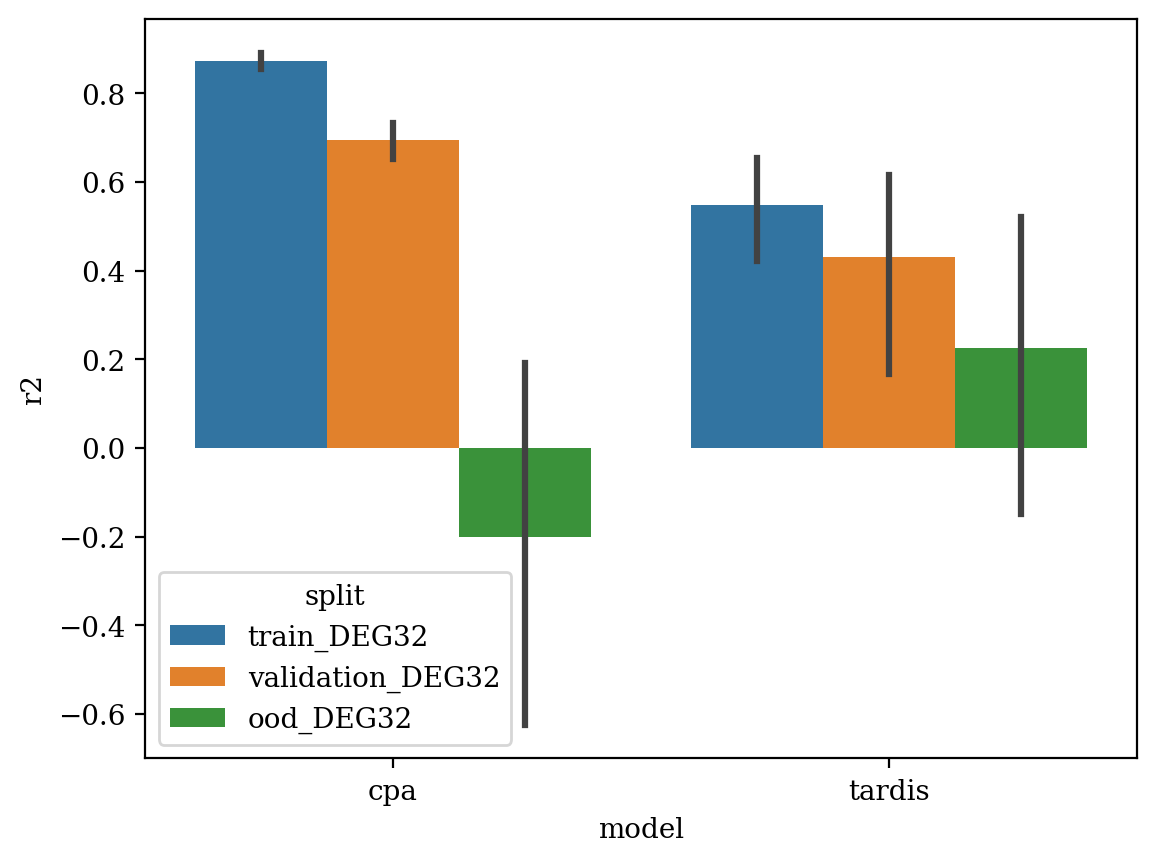

In [18]:
df_melted_ = df_melted[df_melted["split"].str.contains("DEG32")]
df_melted_ = df_melted_[df_melted_["model"] != "baseline"]
sns.barplot(data=df_melted_, x="model", y='r2', hue="split")

<Axes: xlabel='model', ylabel='r2'>

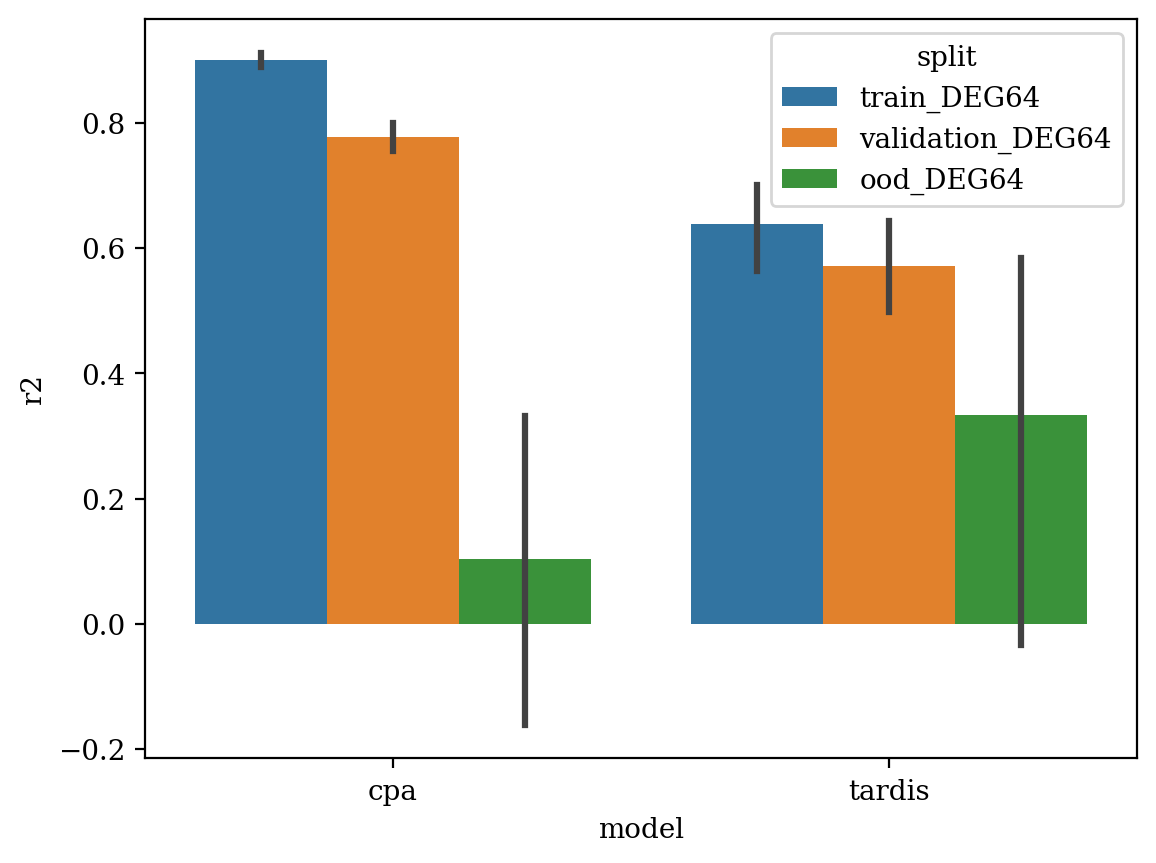

In [19]:
df_melted_ = df_melted[df_melted["split"].str.contains("DEG64")]
df_melted_ = df_melted_[df_melted_["model"] != "baseline"]
sns.barplot(data=df_melted_, x="model", y='r2', hue="split")

<Axes: xlabel='model', ylabel='r2'>

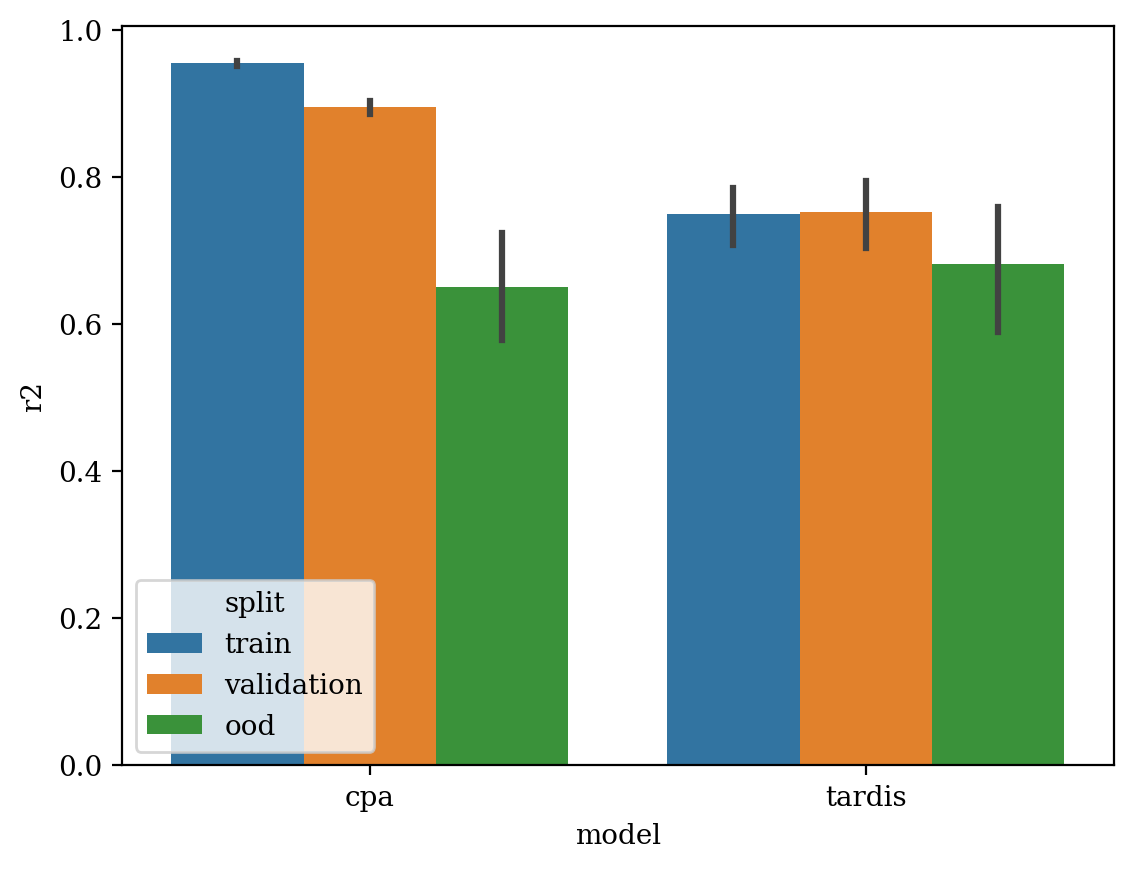

In [20]:
df_melted_ = df_melted[~df_melted["split"].str.contains("DEG")]
df_melted_ = df_melted_[df_melted_["model"] != "baseline"]
sns.barplot(data=df_melted_, x="model", y='r2', hue="split")

In [24]:
df_melted.to_pickle(
    os.path.join(tardis.config.io_directories["processed"], "figures", "figure7_miller.pickle")
)